In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
import itertools
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu"    


torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
ZERO = torch.tensor([0.]).to(device)
torch.set_printoptions(precision=6)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

def adjust_neuron_position(my_model, dims = 3):

    def create_mesh_grid(dims, pts):
        mesh = torch.tensor(list(itertools.product(pts,repeat=dims)))
        vertices = mesh.reshape(len(pts) ** dims, -1) 
        return vertices
    counter = 0 
    # positions = torch.tensor([[0.,0.],[0.,1.],[1.,1.],[1.,0.]])
    pts = torch.tensor([0.,1.])
    positions = create_mesh_grid(dims,pts) 
    neuron_num = my_model.fc1.bias.size(0)
    for i in range(neuron_num): 
        w = my_model.fc1.weight.data[i:i+1,:]
        b = my_model.fc1.bias.data[i]
    #     print(w,b)
        values = torch.matmul(positions,w.T) # + b
        left_end = - torch.max(values)
        right_end = - torch.min(values)
        offset = (right_end - left_end)/50
        if b <= left_end + offset/2 : 
            b = torch.rand(1)*(right_end - left_end - offset) + left_end + offset/2 
            my_model.fc1.bias.data[i] = b 
        if b >= right_end - offset/2 :
            if counter < (dims+1):
#                 print("here")
                counter += 1
            else: # (d + 1) or more 
                b = torch.rand(1)*(right_end - left_end - offset) + left_end + offset/2 
                my_model.fc1.bias.data[i] = b 
    return my_model



## OGA code 

In [30]:
def show_convergence_order2(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex2(err_l2,err_h10,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    l2_order = -1/2-(2*k + 1)/(2*d)
    h1_order =  -1/2-(2*(k-1)+ 1)/(2*d)
    print("neuron num  & \t $\|u-u_n \|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  & \t $ | u -u_n |_{{H^1}}$ & \t order $O(n^{{{:.2f}}})$  \\\ \hline \hline ".format(l2_order,h1_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )


In [3]:
def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights.to(device), integration_points.to(device)


def PiecewiseGQ3D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

    """
    Parameters
    ----------
    target : 
        Target function 
    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature
    """

    # print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,x,indexing='ij')).reshape(3,-1).T
    weight_list = np.array(np.meshgrid(w,w,w,indexing='ij'))
    weights =   (weight_list[0]*weight_list[1]*weight_list[2]).ravel() 

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**3,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**3 /8 

    integration_points = torch.tile(gauss_pts,(Nx**3,1))
    # print("shape of integration_points", integration_points.size())
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(3,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**3)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,3)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 

    return long_weights.to(device), integration_points.to(device)


def generate_relu_dict3D(N_list):
    N1 = N_list[0]
    N2 = N_list[1]
    N3 = N_list[2]
    
    N = N1*N2*N3 
    theta1 = np.linspace(0, pi, N1, endpoint= True).reshape(N1,1)
    theta2 = np.linspace(0, 2*pi, N2, endpoint= False).reshape(N2,1)
    b = np.linspace(-1.732, 1.732, N3,endpoint=False).reshape(N3,1) # threshold: 3**0.5  
    coord3 = np.array(np.meshgrid(theta1,theta2,b,indexing='ij'))
    coord3 = coord3.reshape(3,-1).T # N1*N2*N3 x 3. coordinates for the grid points 
    coord3 = torch.tensor(coord3) 

    f1 = torch.zeros(N,1) 
    f2 = torch.zeros(N,1)
    f3 = torch.zeros(N,1)
    f4 = torch.zeros(N,1)

    f1[:,0] = torch.cos(coord3[:,0]) 
    f2[:,0] = torch.sin(coord3[:,0]) * torch.cos(coord3[:,1])
    f3[:,0] = torch.sin(coord3[:,0]) * torch.sin(coord3[:,1])
    f4[:,0] = coord3[:,2] 

    Wb_tensor = torch.cat([f1,f2,f3,f4],1) # N x 4 
    return Wb_tensor


def generate_relu_dict3D_QMC(s,N0):
#     Sob = torch.quasirandom.SobolEngine(dimension =3, scramble= True, seed=None) 
#     samples = Sob.draw(N0).double() 

#     for i in range(s-1):
#         samples = torch.cat([samples,Sob.draw(N0).double()],0)

    # Monte Carlo 
    samples = torch.rand(s*N0,3) 
    T =torch.tensor([[pi,0,0],[0,2*pi,0],[0,0,1.732*2]])
    shift = torch.tensor([0,0,-1.732])
    samples = samples@T + shift 

    f1 = torch.zeros(s*N0,1) 
    f2 = torch.zeros(s*N0,1)
    f3 = torch.zeros(s*N0,1)
    f4 = torch.zeros(s*N0,1)

    f1[:,0] = torch.cos(samples[:,0]) 
    f2[:,0] = torch.sin(samples[:,0]) * torch.cos(samples[:,1])
    f3[:,0] = torch.sin(samples[:,0]) * torch.sin(samples[:,1])
    f4[:,0] = samples[:,2] 

    Wb_tensor = torch.cat([f1,f2,f3,f4],1) # N x 4 
    return Wb_tensor


def minimize_linear_layer_H1_explicit_assemble_efficient(model,alpha, target, g_N, weights, integration_points, w_bd, pts_bd, activation = 'relu',solver="direct" ,memory=2**29):
    """ -div alpha grad u(x) + u = f 
    Parameters
    ----------
    model: 
        nn model
    alpha:
        alpha function
    target:
        rhs function f 
    pts_bd:
        integration points on the boundary, embdedded in the domain 
    """ 
    ZERO = torch.tensor([0.]).to(device)
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    neuron_num = b.size(0) 
    dim = integration_points.size(1) 
    M = integration_points.size(0)
    coef_alpha = alpha(integration_points) # alpha  

    
    total_size = neuron_num * M # memory, number of floating numbers 
    print('total size: {} {} = {}'.format(neuron_num,M,total_size))
    num_batch = total_size//memory + 1 # divide according to memory
    print("num batches: ",num_batch)
    batch_size = M//num_batch
    jac = torch.zeros(b.size(0),b.size(0)).to(device)
    rhs = torch.zeros(b.size(0),1).to(device)
    
    for j in range(0,M,batch_size): 
        end_index = j + batch_size
        basis_value_col = F.relu(integration_points[j:end_index] @ w.t()+ b)**(model.k) 
        weighted_basis_value_col = basis_value_col * weights[j:end_index] 
        jac += weighted_basis_value_col.t() @ basis_value_col 
        rhs += weighted_basis_value_col.t() @ (target(integration_points[j:end_index,:])) 

    # Assemble the boundary condition term <g,v>_{\Gamma_N} 
    size_pts_bd = int(pts_bd.size(0)/(2*dim))
    if g_N != None: # no batch operations for the boundary part, since it is only rhs on the boundary 
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            # pts_bd_ii = pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            weighted_g_N = -g_ii(pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* w_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(pts_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* w_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(pts_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs += basis_value_bd_col.t() @ weighted_g_N

    # Stiffness matrix term in the jacobian 
     
    for d in range(dim):
        if model.k == 1:  
            for j in range(0,M,batch_size):  
                end_index = j + batch_size 
                basis_value_dxi_col = torch.heaviside(integration_points[j:end_index] @ w.t()+ b, ZERO) * w.t()[d:d+1,:]
                weighted_basis_value_dx_col = basis_value_dxi_col * weights[j:end_index] * coef_alpha[j:end_index] 
                jac += weighted_basis_value_dx_col.t() @ basis_value_dxi_col 
#             basis_value_dxi_col = torch.heaviside(integration_points @ w.t()+ b, zero) * w.t()[d:d+1,:]
#             weighted_basis_value_dx_col = basis_value_dxi_col * weights * coef_alpha 
#             jac += weighted_basis_value_dx_col.t() @ basis_value_dxi_col 

        else:
            for j in range(0,M,batch_size):  
                end_index = j + batch_size 
                basis_value_dxi_col = model.k * F.relu(integration_points[j:end_index] @ w.t()+ b)**(model.k-1) * w.t()[d:d+1,:]
                weighted_basis_value_dx_col = basis_value_dxi_col * weights[j:end_index] * coef_alpha[j:end_index] 
                jac += weighted_basis_value_dx_col.t() @ basis_value_dxi_col 
#             basis_value_dxi_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[d:d+1,:]
#             weighted_basis_value_dx_col = basis_value_dxi_col * weights * coef_alpha  
#             jac += weighted_basis_value_dx_col.t() @ basis_value_dxi_col 

    print("assembling the mass matrix time taken: ", time.time()-start_time) 


    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


def OGANeumannReLU3D(my_model,alpha, target,g_N, u_exact, u_exact_grad, N_list,num_epochs,plot_freq, Nx,order, k =1, rand_deter = 'deter', linear_solver = "direct",memory = 2**29): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    dim = 3 
    gw_expand, integration_points = PiecewiseGQ3D_weights_points(Nx, order = order) 
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)

    # define integration on the boundary 
    gw_expand_bd, integration_points_bd = PiecewiseGQ2D_weights_points(50, order = 3) 
    size_pts_bd = integration_points_bd.size(0) 
    gw_expand_bd_faces = torch.tile(gw_expand_bd,(2*dim,1))

    integration_points_bd_faces = torch.zeros(2*dim*integration_points_bd.size(0),dim).to(device)
    for ind in range(dim): 
        integration_points_bd_faces[2 *ind * size_pts_bd :(2 *ind +1) * size_pts_bd,ind:ind+1] = 0 
        integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,:ind] = integration_points_bd[:,:ind]
        integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,ind+1:] = integration_points_bd[:,ind:]

        integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind:ind+1] = 1
        integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,:ind] = integration_points_bd[:,:ind]        
        integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind+1:] = integration_points_bd[:,ind:]

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1).to(device) 
    if my_model == None: 
        func_values = - target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = - (target(integration_points) - my_model(integration_points).detach())
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    # print(func_values_sqrd.size())
    # print(gw_expand.size()) 
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    ## h1 seminorm 
    if u_exact_grad != None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            err_h10[0] += torch.sum((grad_i(integration_points))**2 * gw_expand)**0.5
    
    start_time = time.time()
    solver = linear_solver

    N0 = np.prod(N_list)
    if rand_deter == 'deter':
        relu_dict_parameters = generate_relu_dict3D(N_list).to(device)
    print("using linear solver: ",solver)
    M2 = integration_points.size(0) # add
    for i in range(num_epochs): 
        start_time = time.time()
        print("epoch: ",i+1, end = '\t')
        if rand_deter == 'rand':
            relu_dict_parameters = generate_relu_dict3D_QMC(1,N0).to(device) 
        if num_neuron == 0: 
            func_values = - target(integration_points)
        else: 
            func_values = - target(integration_points) + my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  

        ### ======================= 
        total_size = M2 * N0 
        num_batch = total_size//memory + 1 
        batch_size = N0//num_batch

        output = torch.zeros(N0,1).to(device)
        print("argmax batch num, ", num_batch) 
        
        for j in range(0,N0,batch_size):  
            end_index = j + batch_size  
            basis_values_batch = (F.relu( torch.matmul(integration_points,relu_dict_parameters[j:end_index,0:dim].T ) - relu_dict_parameters[j:end_index,dim])**k).T # uses broadcasting    
            output[j:end_index,:]  = torch.matmul(basis_values_batch,weight_func_values)[:,:]
        ### ======================= 
        
#         basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:dim].T ) - relu_dict_parameters[:,dim])**k).T # uses broadcasting, # dimension 4 
#         output = torch.matmul(basis_values,weight_func_values) #

        ##========
        # grad u part
        alpha_coef = alpha(integration_points) # alpha 
        if my_model!= None:

            if k == 1:  
                for j in range(0,N0,batch_size):  
                    end_index = j + batch_size 
                    derivative_part = torch.heaviside(integration_points @ (relu_dict_parameters[j:end_index,0:dim].T) - relu_dict_parameters[j:end_index,dim], ZERO) # dimension 4 
                    derivative_part *= alpha_coef # alpha 
                    for dx_i in range(dim): 

                        weight_dbasis_values_dxi =  (derivative_part * relu_dict_parameters.t()[dx_i:dx_i+1,j:end_index]) *gw_expand   
                        dmy_model_dxi = my_model.evaluate_derivative(integration_points,dx_i+1).detach()
                        output[j:end_index,:] += torch.matmul(weight_dbasis_values_dxi.t(), dmy_model_dxi) 

            else:  
                for j in range(0,N0,batch_size):  
                    end_index = j + batch_size 
                    derivative_part = k * F.relu(integration_points @ (relu_dict_parameters[j:end_index,0:dim].T) - relu_dict_parameters[j:end_index,dim])**(k-1) # dimension 4 
                    derivative_part *= alpha_coef # alpha
                    for dx_i in range(dim): 

                        weight_dbasis_values_dxi =  (derivative_part * relu_dict_parameters.t()[dx_i:dx_i+1,j:end_index]) * gw_expand    
                        dmy_model_dxi = my_model.evaluate_derivative(integration_points,dx_i+1).detach()
                        output[j:end_index,:] += torch.matmul(weight_dbasis_values_dxi.t(), dmy_model_dxi) 

        ##========
    
        #Boundary condition term -<g,v>_{\Gamma_N}  
        if g_N != None:
            bcs_N = g_N(dim) 
            for ii, g_ii in bcs_N: 
                
                weighted_g_N = -g_ii(integration_points_bd_faces[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* gw_expand_bd_faces[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
                basis_values_bd_faces = (F.relu( torch.matmul(integration_points_bd_faces[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:],relu_dict_parameters[:,0:dim].T ) - relu_dict_parameters[:,dim])**k).T
                output -= torch.matmul(basis_values_bd_faces,weighted_g_N)
                
                weighted_g_N = g_ii(integration_points_bd_faces[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* gw_expand_bd_faces[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
                basis_values_bd_faces = (F.relu( torch.matmul(integration_points_bd_faces[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:],relu_dict_parameters[:,0:dim].T ) - relu_dict_parameters[:,dim])**k).T
                output -= torch.matmul(basis_values_bd_faces,weighted_g_N)

        
        # output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        output = torch.abs(output)
        neuron_index = torch.argmax(output.flatten())
        print("argmax time taken, ", time.time() - start_time)
        
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:dim]) # dimension 4 
        list_b.append(-relu_dict_parameters[neuron_index,dim])
        num_neuron += 1
        my_model = model(dim,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo Done 
#         alpha = None 
        sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,alpha, target, g_N, gw_expand, integration_points,gw_expand_bd_faces, integration_points_bd_faces,activation = 'relu',solver = solver)

        my_model.fc2.weight.data[0,:] = sol[:]

        model_values = my_model(integration_points).detach()
        # L2 error ||u - u_n||
        diff_values_sqrd = (u_exact(integration_points) - model_values)**2 
        err[i+1]= torch.sum(diff_values_sqrd*gw_expand)**0.5

        # H10 error || grad(u) - grad(u_n) ||
        if u_exact_grad != None:
            for ind, grad_i in enumerate(u_grad):  
                my_model_dxi = my_model.evaluate_derivative(integration_points,ind+1).detach() 
                err_h10[i+1] += torch.sum((grad_i(integration_points) - my_model_dxi)**2 * gw_expand)**0.5
        print("l2 error {:.6f}, h1 error {:.6f}".format(err[i+1],err_h10[i+1]))
    print("time taken: ",time.time() - start_time)
    return err, err_h10.cpu(), my_model




In [ ]:

def u_exact(x):
    return torch.cos(pi*x[:,0:1])*torch.cos( pi*x[:,1:2]) * torch.cos(pi*x[:,2:3])  
def alpha(x): 
    return torch.ones(x.size(0),1).to(device)

def u_exact_grad():
    d = 3 

    def grad_1(x):
        return - pi* torch.sin(pi*x[:,0:1])*torch.cos( pi*x[:,1:2]) * torch.cos(pi*x[:,2:3])   
    def grad_2(x):
        return - pi* torch.cos(pi*x[:,0:1])*torch.sin( pi*x[:,1:2]) * torch.cos(pi*x[:,2:3])  
    def grad_3(x):
        return - pi* torch.cos(pi*x[:,0:1])*torch.cos( pi*x[:,1:2]) * torch.sin(pi*x[:,2:3])   

    u_grad=[grad_1, grad_2,grad_3] 

    return u_grad

def target(x):
    z = (  3 * (pi)**2 + 1)*torch.cos( pi*x[:,0:1])*torch.cos( pi*x[:,1:2] ) * torch.cos(pi*x[:,2:3]) 
    return z 
g_N = None 

dim = 3 
function_name = "cospix" 
filename_write = "data/3DOGA-{}-order.txt".format(function_name)
Nx = 50   
order = 3   
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 
save = False 
write2file = True
rand_deter = 'rand'

for N_list in [[2**3,2**3,2**3]]: # ,[2**6,2**6],[2**7,2**7] 
    # save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 9
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    relu_k = 3 
    err_QMC2, err_h10, my_model = OGANeumannReLU3D(my_model,alpha, target,g_N, u_exact,u_exact_grad, N_list,num_epochs,plot_freq, Nx = Nx, order = order, k = relu_k, rand_deter= rand_deter, linear_solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_NeumannOGA_3D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_NeumannOGA_3D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
        
    show_convergence_order2(err_QMC2,err_h10,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex2(err_QMC2,err_h10,exponent,k=relu_k,d = dim)


## Adam 3D 

In [42]:
## helper functions 
def compute_l2_error(u_exact,my_model,M,batch_size_2,weights,integration_points): 
    err = 0 
    if my_model == None: 
        for jj in range(0,M,batch_size_2): 
            end_index = jj + batch_size_2 
            func_values = u_exact(integration_points[jj:end_index,:])
            err += torch.sum(func_values**2 * weights[jj:end_index,:])
    else: 
        for jj in range(0,M,batch_size_2): 
            end_index = jj + batch_size_2 
            func_values = u_exact(integration_points[jj:end_index,:]) - my_model(integration_points[jj:end_index,:]).detach()
            err += torch.sum(func_values**2 * weights[jj:end_index,:])
    return err**0.5  

def compute_gradient_error(u_exact_grad,my_model,M,batch_size_2,weights,integration_points):
    """
    Parameters
    ----------
    u_exact_grad: list or None
        a list that contains ways of evaluating partial derivatives that gives the gradient  
    """
    err_h10 = 0 
     # initial gradient error 
    if u_exact_grad != None and my_model!=None:
        u_grad = u_exact_grad() 
        for ii, grad_i in enumerate(u_grad): 
            for jj in range(0,M,batch_size_2): 
                end_index = jj + batch_size_2 
                my_model_dxi = my_model.evaluate_derivative(integration_points[jj:end_index,:],ii+1).detach() 
                err_h10 += torch.sum((grad_i(integration_points[jj:end_index,:]) - my_model_dxi)**2 * weights[jj:end_index,:])
    elif u_exact_grad != None and my_model==None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            for jj in range(0,M,batch_size_2): 
                end_index = jj + batch_size_2 
                err_h10 += torch.sum((grad_i(integration_points[jj:end_index,:]))**2 * weights[jj:end_index,:])
    return err_h10**0.5 

def AdamOrGD_train(my_model, u_exact, u_exact_grad,rhs,learning_rate,num_epochs,initialize_,gd_or_adam, plot = True): 
    """Training SNN using Adam or GD

    Parameters
    ----------
    my_model : nn model class 
        Shallow neural network model 
    target : function
        the target function
    learning_rate : float 
        learning rate for neural network training 
    num_epochs : int 
        number of epochs
    backtracking : bool
        use backtracking strategy or not
    initialize_ : function
        initialize the nn parameters

    Returns
    -------
    err : torch tensor
        L2 error history with respect to the epoch number 
    my_model : nn model class 
        trained nn model
    """
    Nx =  20  
    order = 2  
    integration_weights, integration_points = PiecewiseGQ3D_weights_points(Nx, order = order) 
    start = time.time()
    hidden_size1 = my_model.fc1.bias.size(0)
    print("current hidden layer size: ",hidden_size1)

    # Data to be recorded
    err_l2 = torch.zeros(num_epochs+1, 1) #include initial loss 
    err_h1 = torch.zeros(num_epochs+1, 1) #include initial loss 
    # Parameter initialization
    if initialize_ != None: 
        initialize_(my_model,rhs) #initialize_(my_model.parameters())

    def loss_function(model,integration_points,integration_weights):
        return 0.5 * integration_weights.t() @ ( torch.pow(model(integration_points)-rhs(integration_points),2).to(device) \
                     + torch.pow(model.evaluate_derivative(integration_points,1),2).to(device) \
                    +torch.pow(model.evaluate_derivative(integration_points,2),2).to(device) \
                    + torch.pow(model.evaluate_derivative(integration_points,3),2).to(device) ) 
    
    # compute the initial L2 and H1 error 
    memory = 2**28 
    M = integration_points.size(0) 
    num_neuron = 0 if my_model == None else int(my_model.fc1.bias.detach().data.size(0))
    total_size2 = M*(num_neuron+1)
    num_batch2 = total_size2//memory + 1 
    batch_size_2 = M//num_batch2 # integration points 
    with torch.no_grad(): #compute the L2 and H1 error 
        err_l2[0] = compute_l2_error(u_exact,my_model,M,batch_size_2,integration_weights,integration_points)
        err_h1[0] = compute_gradient_error(u_exact_grad,my_model,M,batch_size_2,integration_weights,integration_points)

    # Define optimizer 
    if gd_or_adam == "adam": 
        optimizer1 = optim.Adam(my_model.parameters(), lr=learning_rate)
    elif gd_or_adam == "gd":
        optimizer1 = optim.SGD(my_model.parameters(), lr=learning_rate)

    # Training process
    lr = learning_rate  
    for epoch in range(num_epochs):
         
        for param_group in optimizer1.param_groups:
            param_group['lr'] = lr #  * (0.98 ** ((epoch + 1) // 10))
        optimizer1.zero_grad()
        loss = loss_function(my_model,integration_points,integration_weights)
        loss.backward() # compute the gradients in optimizer1

        optimizer1.step()

        with torch.no_grad(): #compute the L2 and H1 error  
            err_l2[epoch+1] = compute_l2_error(u_exact,my_model,M,batch_size_2,integration_weights,integration_points)
            err_h1[epoch+1] = compute_gradient_error(u_exact_grad,my_model,M,batch_size_2,integration_weights,integration_points)

        # Print errors every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, L2 Error: {err_l2[epoch+1].data.item():.2e}, H1 Error: {err_h1[epoch+1].data.item():.2e}')
    # Plot 1. L^2 error history
    if plot: 
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.semilogy(range(num_epochs+1), err_l2.detach().cpu().numpy(), 'b-', label='L2 Error')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Error')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2) 
        plt.semilogy(range(num_epochs+1), err_h1.detach().cpu().numpy(), 'r-', label='H1 Error')
        plt.xlabel('Epoch')
        plt.ylabel('H1 Error')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    end = time.time()
    print(f"{end - start:.3} (s)")
    return min(err_l2), min(err_h1), my_model


In [ ]:

def u_exact(x):
    return torch.cos(pi*x[:,0:1])*torch.cos( pi*x[:,1:2]) * torch.cos(pi*x[:,2:3])  
def alpha(x): 
    return torch.ones(x.size(0),1).to(device)

def u_exact_grad():
    d = 3 

    def grad_1(x):
        return - pi* torch.sin(pi*x[:,0:1])*torch.cos( pi*x[:,1:2]) * torch.cos(pi*x[:,2:3])   
    def grad_2(x):
        return - pi* torch.cos(pi*x[:,0:1])*torch.sin( pi*x[:,1:2]) * torch.cos(pi*x[:,2:3])  
    def grad_3(x):
        return - pi* torch.cos(pi*x[:,0:1])*torch.cos( pi*x[:,1:2]) * torch.sin(pi*x[:,2:3])   

    u_grad=[grad_1, grad_2,grad_3] 

    return u_grad

def target(x):
    z = (  3 * (pi)**2 + 1)*torch.cos( pi*x[:,0:1])*torch.cos( pi*x[:,1:2] ) * torch.cos(pi*x[:,2:3]) 
    return z 

if __name__ == "__main__":
    learning_rate = 1e-2
    backtracking = True
    initialize_ = None 
    plot = False 
    save = False 
    
    num_epochs = 20
    num_trials =5 
    gd_or_adam = "adam"
    
    err_l2_list = []
    err_h1_list = []
    neuron_num_list = []
    for exponent in [4,5]: # Try with 2^6 nodes first
        neuron_num_list.append(2**exponent) 
        err_l2_trials = torch.zeros(num_trials)
        err_h1_trials = torch.zeros(num_trials)
        for trial in range(num_trials):
            my_model = model(3, 2**exponent, 1, k=3) 
            err_l2, err_h10, my_model = AdamOrGD_train(my_model,
                                                      u_exact,
                                                      u_exact_grad,  
                                                      target,
                                                      learning_rate,
                                                      num_epochs,
                                                      initialize_,
                                                      gd_or_adam,
                                                      plot=plot)
            err_l2_trials[trial] = err_l2
            err_h1_trials[trial] = err_h10
            if save:
                torch.save(my_model.state_dict(), gd_or_adam+"-3d-"+str(exponent)+"-"+str(trial)+".pt")
                torch.save(err_l2, gd_or_adam+"-3d-"+str(exponent)+"-"+str(trial)+"-err_l2.pt")
                torch.save(err_h10, gd_or_adam+"-3d-"+str(exponent)+"-"+str(trial)+"-err_h10.pt")
        err_l2_list.append(err_l2_trials.mean().data.item())
        err_h1_list.append(err_h1_trials.mean().data.item())


print(err_l2_list)
print(err_h1_list)

# Convert lists to numpy arrays for easier manipulation
neuron_nums = np.array(neuron_num_list)
l2_errors = np.array(err_l2_list)
h1_errors = np.array(err_h1_list)

# Calculate convergence rates
l2_rates = []
h1_rates = []
for i in range(1, len(neuron_nums)):
    l2_rate = np.log(l2_errors[i-1]/l2_errors[i])/np.log(neuron_nums[i]/neuron_nums[i-1])
    h1_rate = np.log(h1_errors[i-1]/h1_errors[i])/np.log(neuron_nums[i]/neuron_nums[i-1])
    l2_rates.append(l2_rate)
    h1_rates.append(h1_rate)


filename = "3DNeumannAdamErrors.txt"
with open(filename, 'a') as f:
    f.write("\n")
    f.write(f"L2 Error: {err_l2_list}\n")
    f.write(f"H1 Error: {err_h1_list}\n")
    f.write(f"L2 Rates: {l2_rates}\n")
    f.write(f"H1 Rates: {h1_rates}\n")

 

current hidden layer size:  16
Epoch 0, L2 Error: 3.58e-01, H1 Error: 1.94e+00
Epoch 10, L2 Error: 3.51e-01, H1 Error: 1.90e+00
1.12 (s)
current hidden layer size:  16
Epoch 0, L2 Error: 3.58e-01, H1 Error: 1.94e+00
Epoch 10, L2 Error: 3.53e-01, H1 Error: 1.92e+00
0.791 (s)
current hidden layer size:  16
Epoch 0, L2 Error: 4.02e-01, H1 Error: 1.96e+00
Epoch 10, L2 Error: 3.58e-01, H1 Error: 1.92e+00
0.835 (s)
current hidden layer size:  16
Epoch 0, L2 Error: 3.59e-01, H1 Error: 1.93e+00
Epoch 10, L2 Error: 3.51e-01, H1 Error: 1.89e+00
0.881 (s)
current hidden layer size:  16
Epoch 0, L2 Error: 3.74e-01, H1 Error: 1.93e+00
Epoch 10, L2 Error: 3.51e-01, H1 Error: 1.90e+00
0.852 (s)
current hidden layer size:  32
Epoch 0, L2 Error: 4.84e-01, H1 Error: 2.01e+00
Epoch 10, L2 Error: 3.49e-01, H1 Error: 1.90e+00
1.43 (s)
current hidden layer size:  32
Epoch 0, L2 Error: 3.52e-01, H1 Error: 1.90e+00
Epoch 10, L2 Error: 3.32e-01, H1 Error: 1.79e+00
1.3 (s)
current hidden layer size:  32
Epoch 0

In [44]:

print(err_l2_list)
print(err_h1_list)

filename = "3DNeumannAdamErrors.txt"
with open(filename, 'a') as f:
    f.write(f"L2 Error: {err_l2_list}\n")
    f.write(f"H1 Error: {err_h1_list}\n")

[tensor(0.339318), tensor(0.327731)]
[tensor(1.837626), tensor(1.762321)]


## Adam 1D 

In [27]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

## helper functions 
def compute_l2_error(u_exact, my_model, M, batch_size_2, weights, integration_points): 
    err = 0 
    if my_model == None: 
        for jj in range(0, M, batch_size_2): 
            end_index = jj + batch_size_2 
            func_values = u_exact(integration_points[jj:end_index,:])
            err += torch.sum(func_values**2 * weights[jj:end_index,:])
    else: 
        for jj in range(0, M, batch_size_2): 
            end_index = jj + batch_size_2 
            func_values = u_exact(integration_points[jj:end_index,:]) - my_model(integration_points[jj:end_index,:]).detach()
            err += torch.sum(func_values**2 * weights[jj:end_index,:])
    return err**0.5  

def compute_gradient_error(u_exact_grad, my_model, M, batch_size_2, weights, integration_points):
    """
    Parameters
    ----------
    u_exact_grad: list or None
        a list that contains ways of evaluating partial derivatives that gives the gradient  
    """
    err_h10 = 0 
     # initial gradient error 
    if u_exact_grad != None and my_model!=None:
        u_grad = u_exact_grad() 
        for ii, grad_i in enumerate(u_grad): 
            for jj in range(0, M, batch_size_2): 
                end_index = jj + batch_size_2 
                my_model_dxi = my_model.evaluate_derivative(integration_points[jj:end_index,:], ii+1).detach() 
                err_h10 += torch.sum((grad_i(integration_points[jj:end_index,:]) - my_model_dxi)**2 * weights[jj:end_index,:])
    elif u_exact_grad != None and my_model==None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            for jj in range(0, M, batch_size_2): 
                end_index = jj + batch_size_2 
                err_h10 += torch.sum((grad_i(integration_points[jj:end_index,:]))**2 * weights[jj:end_index,:])
    return err_h10**0.5 

def AdamOrGD_train(my_model, u_exact, u_exact_grad, rhs, learning_rate, num_epochs, initialize_, gd_or_adam, plot = True): 
    """Training SNN using Adam or GD

    Parameters
    ----------
    my_model : nn model class 
        Shallow neural network model 
    target : function
        the target function
    learning_rate : float 
        learning rate for neural network training 
    num_epochs : int 
        number of epochs
    backtracking : bool
        use backtracking strategy or not
    initialize_ : function
        initialize the nn parameters

    Returns
    -------
    err : torch tensor
        L2 error history with respect to the epoch number 
    my_model : nn model class 
        trained nn model
    """
    Nx = 512 
    order = 2 
    integration_weights, integration_points = PiecewiseGQ1D_weights_points(-1,1,Nx, order = order) 
    start = time.time()
    hidden_size1 = my_model.fc1.bias.size(0)
    print("current hidden layer size: ", hidden_size1)

    # Data to be recorded
    err_l2 = torch.zeros(num_epochs+1, 1) #include initial loss 
    err_h1 = torch.zeros(num_epochs+1, 1) #include initial loss 
    # Parameter initialization
    if initialize_ != None: 
        initialize_(my_model, rhs) #initialize_(my_model.parameters())

    def loss_function(model, integration_points, integration_weights):
        return 0.5 * integration_weights.t() @ (torch.pow(model(integration_points)-rhs(integration_points), 2).to(device) \
                     + torch.pow(model.evaluate_derivative(integration_points, 1), 2).to(device))
    
    # compute the initial L2 and H1 error 
    memory = 2**28 
    M = integration_points.size(0) 
    num_neuron = 0 if my_model == None else int(my_model.fc1.bias.detach().data.size(0))
    total_size2 = M*(num_neuron+1)
    num_batch2 = total_size2//memory + 1 
    batch_size_2 = M//num_batch2 # integration points 
    with torch.no_grad(): #compute the L2 and H1 error 
        err_l2[0] = compute_l2_error(u_exact, my_model, M, batch_size_2, integration_weights, integration_points)
        err_h1[0] = compute_gradient_error(u_exact_grad, my_model, M, batch_size_2, integration_weights, integration_points)

    # Define optimizer 
    if gd_or_adam == "adam": 
        optimizer1 = optim.Adam(my_model.parameters(), lr=learning_rate)
    elif gd_or_adam == "gd":
        optimizer1 = optim.SGD(my_model.parameters(), lr=learning_rate)

    # Training process
    lr = learning_rate  
    for epoch in range(num_epochs):
         
        for param_group in optimizer1.param_groups:
            param_group['lr'] = lr #  * (0.98 ** ((epoch + 1) // 10))
        optimizer1.zero_grad()
        loss = loss_function(my_model, integration_points, integration_weights)
        loss.backward() # compute the gradients in optimizer1

        lr = learning_rate 
        for param_group in optimizer1.param_groups:
            param_group['lr'] = lr * (0.98 ** ((epoch + 1) // 5000)) # Learning rate schedule
        optimizer1.step()

        with torch.no_grad(): #compute the L2 and H1 error  
            err_l2[epoch+1] = compute_l2_error(u_exact, my_model, M, batch_size_2, integration_weights, integration_points)
            err_h1[epoch+1] = compute_gradient_error(u_exact_grad, my_model, M, batch_size_2, integration_weights, integration_points)

        # Print errors every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, L2 Error: {err_l2[epoch+1].data.item():.2e}, H1 Error: {err_h1[epoch+1].data.item():.2e}')
    # Plot 1. L^2 error history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.semilogy(range(num_epochs+1), err_l2.detach().cpu().numpy(), 'b-', label='L2 Error')
    plt.xlabel('Epoch')
    plt.ylabel('L2 Error')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2) 
    plt.semilogy(range(num_epochs+1), err_h1.detach().cpu().numpy(), 'r-', label='H1 Error')
    plt.xlabel('Epoch')
    plt.ylabel('H1 Error')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    end = time.time()
    print(f"{end - start:.3} (s)")
    return min(err_l2), min(err_h1), my_model


current hidden layer size:  16
Epoch 0, L2 Error: 1.36e+00, H1 Error: 3.09e+00
Epoch 10, L2 Error: 1.13e+00, H1 Error: 2.28e+00
Epoch 20, L2 Error: 1.13e+00, H1 Error: 2.05e+00
Epoch 30, L2 Error: 7.28e-01, H1 Error: 2.01e+00
Epoch 40, L2 Error: 4.75e-01, H1 Error: 1.98e+00
Epoch 50, L2 Error: 3.92e-01, H1 Error: 1.95e+00
Epoch 60, L2 Error: 4.10e-01, H1 Error: 1.89e+00
Epoch 70, L2 Error: 3.93e-01, H1 Error: 1.82e+00
Epoch 80, L2 Error: 3.60e-01, H1 Error: 1.69e+00
Epoch 90, L2 Error: 3.18e-01, H1 Error: 1.49e+00
Epoch 100, L2 Error: 2.59e-01, H1 Error: 1.24e+00
Epoch 110, L2 Error: 2.02e-01, H1 Error: 9.74e-01
Epoch 120, L2 Error: 2.19e-01, H1 Error: 8.29e-01
Epoch 130, L2 Error: 1.90e-01, H1 Error: 7.22e-01
Epoch 140, L2 Error: 1.27e-01, H1 Error: 6.82e-01
Epoch 150, L2 Error: 1.09e-01, H1 Error: 6.46e-01
Epoch 160, L2 Error: 1.09e-01, H1 Error: 6.15e-01
Epoch 170, L2 Error: 9.44e-02, H1 Error: 5.85e-01
Epoch 180, L2 Error: 8.72e-02, H1 Error: 5.55e-01
Epoch 190, L2 Error: 8.06e-02,

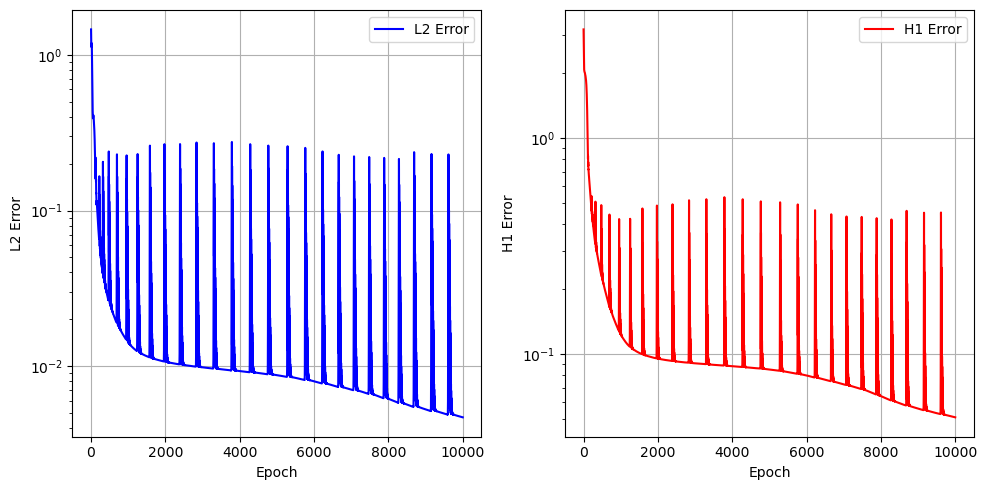

20.5 (s)
current hidden layer size:  32
Epoch 0, L2 Error: 1.14e+00, H1 Error: 3.42e+00
Epoch 10, L2 Error: 1.04e+00, H1 Error: 2.32e+00
Epoch 20, L2 Error: 1.04e+00, H1 Error: 2.11e+00
Epoch 30, L2 Error: 6.18e-01, H1 Error: 2.00e+00
Epoch 40, L2 Error: 4.45e-01, H1 Error: 1.83e+00
Epoch 50, L2 Error: 3.64e-01, H1 Error: 1.63e+00
Epoch 60, L2 Error: 3.41e-01, H1 Error: 1.45e+00
Epoch 70, L2 Error: 2.70e-01, H1 Error: 1.25e+00
Epoch 80, L2 Error: 2.30e-01, H1 Error: 1.04e+00
Epoch 90, L2 Error: 1.70e-01, H1 Error: 8.17e-01
Epoch 100, L2 Error: 1.03e-01, H1 Error: 5.77e-01
Epoch 110, L2 Error: 6.14e-02, H1 Error: 3.66e-01
Epoch 120, L2 Error: 3.03e-02, H1 Error: 1.91e-01
Epoch 130, L2 Error: 6.46e-02, H1 Error: 1.61e-01
Epoch 140, L2 Error: 3.57e-02, H1 Error: 9.72e-02
Epoch 150, L2 Error: 1.25e-02, H1 Error: 6.92e-02
Epoch 160, L2 Error: 6.45e-03, H1 Error: 6.63e-02
Epoch 170, L2 Error: 1.04e-02, H1 Error: 6.77e-02
Epoch 180, L2 Error: 8.34e-03, H1 Error: 6.64e-02
Epoch 190, L2 Error: 

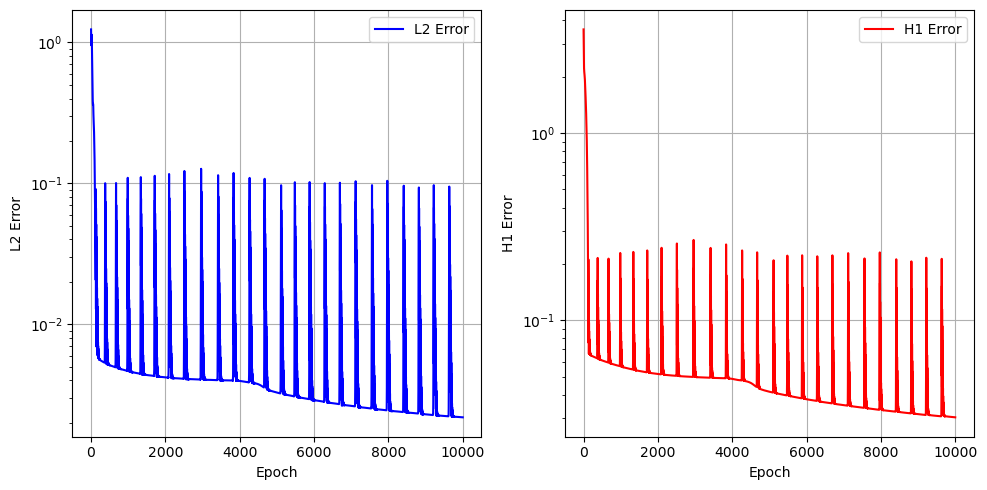

23.5 (s)
current hidden layer size:  64
Epoch 0, L2 Error: 1.16e+00, H1 Error: 3.31e+00
Epoch 10, L2 Error: 1.02e+00, H1 Error: 2.08e+00
Epoch 20, L2 Error: 5.39e-01, H1 Error: 1.88e+00
Epoch 30, L2 Error: 4.72e-01, H1 Error: 1.61e+00
Epoch 40, L2 Error: 3.08e-01, H1 Error: 1.35e+00
Epoch 50, L2 Error: 2.41e-01, H1 Error: 1.19e+00
Epoch 60, L2 Error: 2.57e-01, H1 Error: 9.95e-01
Epoch 70, L2 Error: 1.84e-01, H1 Error: 8.59e-01
Epoch 80, L2 Error: 1.50e-01, H1 Error: 7.15e-01
Epoch 90, L2 Error: 1.21e-01, H1 Error: 5.67e-01
Epoch 100, L2 Error: 1.25e-01, H1 Error: 4.77e-01
Epoch 110, L2 Error: 5.55e-02, H1 Error: 3.33e-01
Epoch 120, L2 Error: 5.12e-02, H1 Error: 2.64e-01
Epoch 130, L2 Error: 4.05e-02, H1 Error: 1.95e-01
Epoch 140, L2 Error: 2.34e-02, H1 Error: 1.44e-01
Epoch 150, L2 Error: 1.41e-02, H1 Error: 1.07e-01
Epoch 160, L2 Error: 1.24e-02, H1 Error: 8.92e-02
Epoch 170, L2 Error: 9.85e-03, H1 Error: 7.88e-02
Epoch 180, L2 Error: 8.03e-03, H1 Error: 7.33e-02
Epoch 190, L2 Error: 

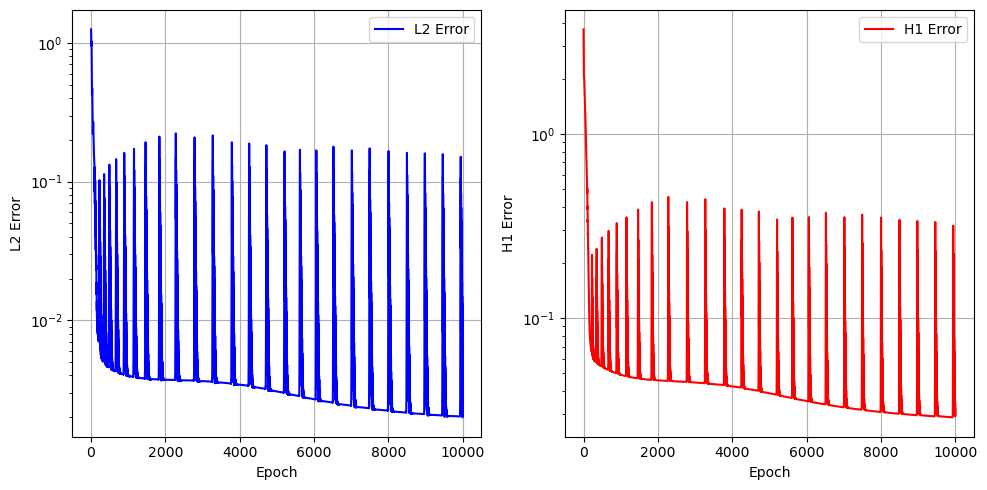

29.0 (s)
current hidden layer size:  128
Epoch 0, L2 Error: 9.63e-01, H1 Error: 2.69e+00
Epoch 10, L2 Error: 7.28e-01, H1 Error: 2.07e+00
Epoch 20, L2 Error: 4.01e-01, H1 Error: 1.89e+00
Epoch 30, L2 Error: 4.15e-01, H1 Error: 1.52e+00
Epoch 40, L2 Error: 3.98e-01, H1 Error: 9.50e-01
Epoch 50, L2 Error: 1.13e-01, H1 Error: 4.16e-01
Epoch 60, L2 Error: 7.97e-02, H1 Error: 3.46e-01
Epoch 70, L2 Error: 6.34e-02, H1 Error: 1.75e-01
Epoch 80, L2 Error: 2.44e-02, H1 Error: 9.71e-02
Epoch 90, L2 Error: 1.74e-02, H1 Error: 7.69e-02
Epoch 100, L2 Error: 8.44e-03, H1 Error: 5.01e-02
Epoch 110, L2 Error: 6.70e-03, H1 Error: 5.23e-02
Epoch 120, L2 Error: 4.87e-03, H1 Error: 4.66e-02
Epoch 130, L2 Error: 4.89e-03, H1 Error: 4.62e-02
Epoch 140, L2 Error: 3.61e-03, H1 Error: 4.50e-02
Epoch 150, L2 Error: 3.43e-03, H1 Error: 4.48e-02
Epoch 160, L2 Error: 3.67e-03, H1 Error: 4.45e-02
Epoch 170, L2 Error: 3.60e-03, H1 Error: 4.44e-02
Epoch 180, L2 Error: 3.49e-03, H1 Error: 4.42e-02
Epoch 190, L2 Error:

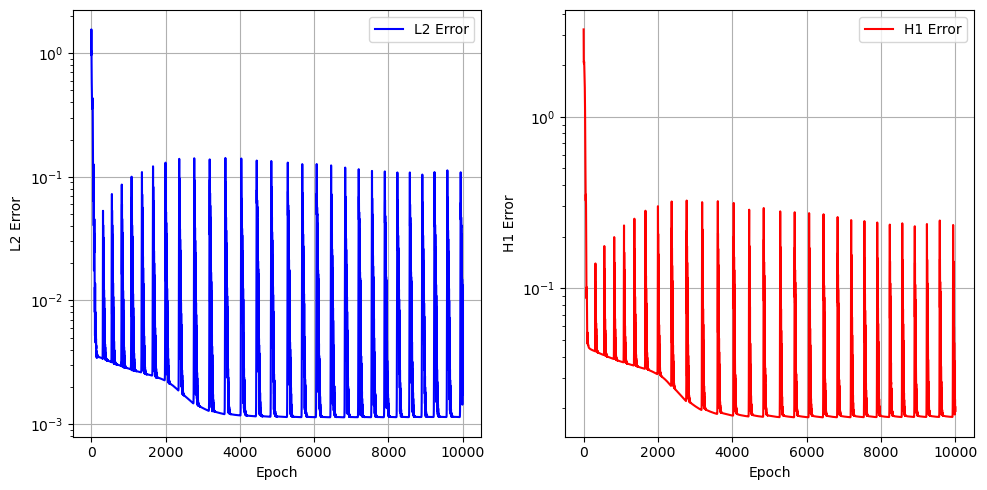

34.5 (s)
current hidden layer size:  256
Epoch 0, L2 Error: 9.68e-01, H1 Error: 2.09e+00
Epoch 10, L2 Error: 4.43e-01, H1 Error: 1.69e+00
Epoch 20, L2 Error: 3.76e-01, H1 Error: 1.03e+00
Epoch 30, L2 Error: 5.60e-02, H1 Error: 3.36e-01
Epoch 40, L2 Error: 1.16e-01, H1 Error: 3.38e-01
Epoch 50, L2 Error: 4.79e-02, H1 Error: 1.58e-01
Epoch 60, L2 Error: 3.79e-02, H1 Error: 1.51e-01
Epoch 70, L2 Error: 4.83e-02, H1 Error: 1.24e-01
Epoch 80, L2 Error: 3.86e-02, H1 Error: 1.03e-01
Epoch 90, L2 Error: 1.39e-02, H1 Error: 7.07e-02
Epoch 100, L2 Error: 1.70e-02, H1 Error: 7.48e-02
Epoch 110, L2 Error: 6.60e-03, H1 Error: 6.15e-02
Epoch 120, L2 Error: 9.48e-02, H1 Error: 2.04e-01
Epoch 130, L2 Error: 3.32e-02, H1 Error: 8.71e-02
Epoch 140, L2 Error: 3.29e-02, H1 Error: 8.69e-02
Epoch 150, L2 Error: 1.56e-02, H1 Error: 6.07e-02
Epoch 160, L2 Error: 1.12e-02, H1 Error: 5.53e-02
Epoch 170, L2 Error: 4.87e-03, H1 Error: 5.04e-02
Epoch 180, L2 Error: 4.97e-03, H1 Error: 4.94e-02
Epoch 190, L2 Error:

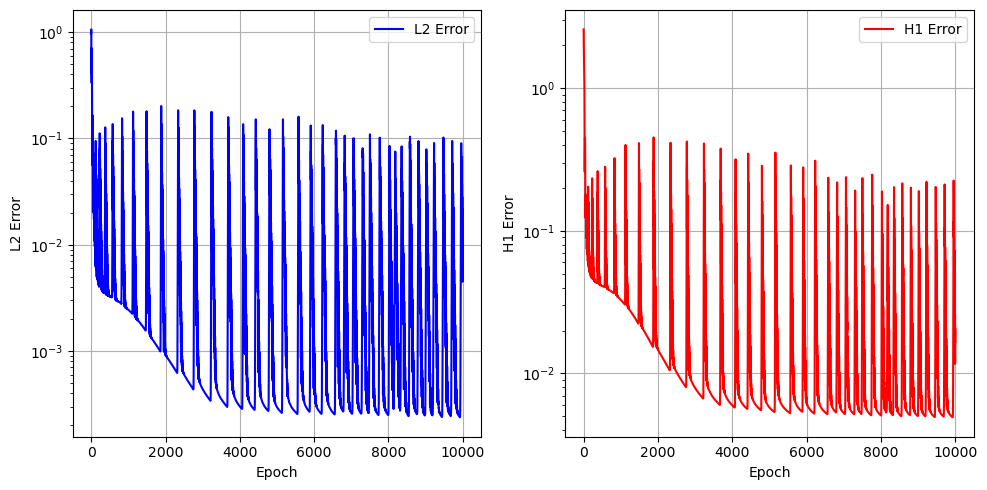

44.7 (s)
[tensor(0.004692), tensor(0.002188), tensor(0.001995), tensor(0.001135), tensor(0.000238)]
[tensor(0.051165), tensor(0.030254), tensor(0.028861), tensor(0.017690), tensor(0.004922)]


In [29]:

def u_exact(x):
    return torch.cos(pi*x[:,0:1])
def alpha(x): 
    return torch.ones(x.size(0),1).to(device)

def u_exact_grad():
    d = 1 

    def grad_1(x):
        return - pi* torch.sin(pi*x[:,0:1])

    u_grad=[grad_1] 

    return u_grad

def target(x):
    z = (  (pi)**2 + 1)*torch.cos( pi*x[:,0:1])
    return z 

if __name__ == "__main__":
    learning_rate = 1e-2
    initialize_ = None 
    plot = True
    save = False 
    
    num_epochs = 10000
    num_trials = 1
    gd_or_adam = "adam"
    
    neuron_num_list = [] 
    err_l2_list = [] 
    err_h1_list = []
    for exponent in [4,5,6,7,8]: # Try with 2^6 nodes first
        neuron_num_list.append(2**exponent)
        for trial in range(num_trials):
            my_model = model(1, 2**exponent, 1, k=3) 
            err_l2, err_h10, my_model = AdamOrGD_train(my_model,
                                                      u_exact, 
                                                      u_exact_grad,
                                                      target,
                                                      learning_rate,
                                                      num_epochs,
                                                      initialize_,
                                                      gd_or_adam,
                                                      plot=plot)
            
            if save:
                torch.save(my_model.state_dict(), gd_or_adam+"-1d-"+str(exponent)+"-"+str(trial)+".pt")
                torch.save(err_l2, gd_or_adam+"-1d-"+str(exponent)+"-"+str(trial)+"-err_l2.pt")
                torch.save(err_h10, gd_or_adam+"-1d-"+str(exponent)+"-"+str(trial)+"-err_h10.pt")
            err_l2_list.append(min(err_l2))
            err_h1_list.append(min(err_h10))

print(err_l2_list)
print(err_h1_list)


L2 Error Convergence Rates:
Between 16 and 32 neurons: 1.1003
Between 32 and 64 neurons: 0.1333
Between 64 and 128 neurons: 0.8139
Between 128 and 256 neurons: 2.2548

H1 Error Convergence Rates:
Between 16 and 32 neurons: 0.7581
Between 32 and 64 neurons: 0.0680
Between 64 and 128 neurons: 0.7062
Between 128 and 256 neurons: 1.8458

Average L2 convergence rate: 1.0756
Average H1 convergence rate: 0.8445


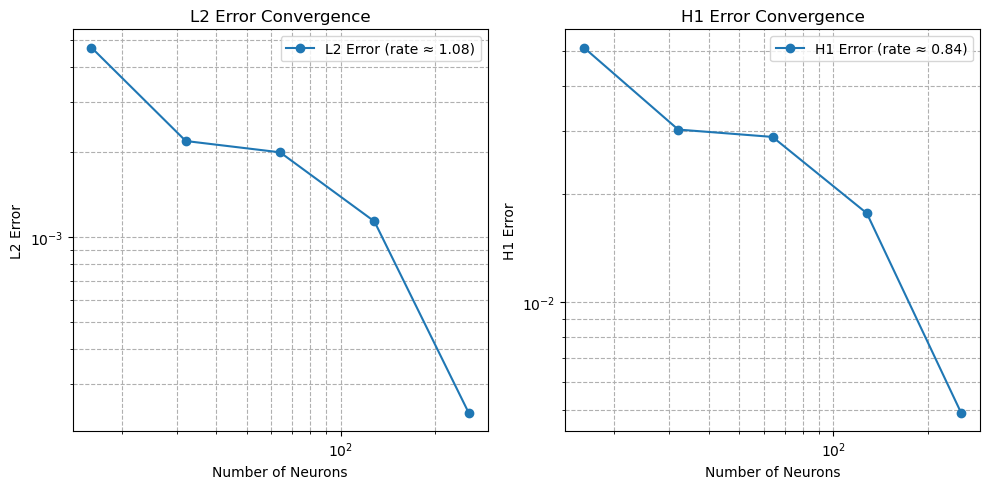

In [ ]:
err_h1_list, err_l2_list, neuron_num_list
# Plot convergence rates
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays for easier manipulation
neuron_nums = np.array(neuron_num_list)
l2_errors = np.array(err_l2_list)
h1_errors = np.array(err_h1_list)

# Calculate convergence rates
l2_rates = []
h1_rates = []
for i in range(1, len(neuron_nums)):
    l2_rate = np.log(l2_errors[i-1]/l2_errors[i])/np.log(neuron_nums[i]/neuron_nums[i-1])
    h1_rate = np.log(h1_errors[i-1]/h1_errors[i])/np.log(neuron_nums[i]/neuron_nums[i-1])
    l2_rates.append(l2_rate)
    h1_rates.append(h1_rate)

# Print convergence rates
print("L2 Error Convergence Rates:")
for i, rate in enumerate(l2_rates):
    print(f"Between {neuron_nums[i]} and {neuron_nums[i+1]} neurons: {rate:.4f}")

print("\nH1 Error Convergence Rates:")
for i, rate in enumerate(h1_rates):
    print(f"Between {neuron_nums[i]} and {neuron_nums[i+1]} neurons: {rate:.4f}")

# Calculate average convergence rates
avg_l2_rate = np.mean(l2_rates)
avg_h1_rate = np.mean(h1_rates)
print(f"\nAverage L2 convergence rate: {avg_l2_rate:.4f}")
print(f"Average H1 convergence rate: {avg_h1_rate:.4f}")

# Plot errors vs number of neurons on log-log scale
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.loglog(neuron_nums, l2_errors, 'o-', label=f'L2 Error (rate ≈ {avg_l2_rate:.2f})')
plt.xlabel('Number of Neurons')
plt.ylabel('L2 Error')
plt.title('L2 Error Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.subplot(1, 2, 2)
plt.loglog(neuron_nums, h1_errors, 'o-', label=f'H1 Error (rate ≈ {avg_h1_rate:.2f})')
plt.xlabel('Number of Neurons')
plt.ylabel('H1 Error')
plt.title('H1 Error Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()
plt.show()

